# Setup

In [29]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [30]:
%matplotlib inline

In [31]:
from relaxed.plot_defaults import *

In [32]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [33]:
from relaxed.analysis import setup, get_quantiles, gaussian_conditional, get_am, get_a2_from_am, get_lam

# Data

In [34]:
# catalog
hcat, indices, scales = setup('m11', path='../../output')
cvir = hcat.cat['cvir']

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../output')
a2 = get_a2_from_am(am, mass_bins)

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape, mass_bins.shape, a2.shape, cvir.shape)

(9999, 98) (98,) (9999,) (9999,)


In [35]:
 # remove nan's from lam along the way, like ~600 haloes.
keep, lam, cvir, a2 = get_lam(am, cvir, a2)
am = am[keep]
print(sum(keep), lam.shape, cvir.shape, a2.shape, am.shape)

9449 (9449, 98) (9449,) (9449,) (9449, 98)


In [36]:
# train/test split.
lam_train, lam_test, cvir_train, cvir_test, a2_train, a2_test, am_train, am_test = train_test_split(lam, cvir, a2, am, test_size=0.33)
print(cvir_train.shape)
print(cvir_test.shape)

(6330,)
(3119,)


# Train

In [37]:
from relaxed.analysis import training_suite

In [38]:
cvir_models = training_suite(cvir_train, am_train, mass_bins=mass_bins, suite=("LN-RS", "CAM", "MG-A2", "MV-LLR", "MV-LR", "MG-TFC"))

# Plots

## Combined histogram of residuals

In [59]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(lam_test, X_test, trained_models, colors=('r', 'b', 'g'), names=("CAM"), n_bins=50, latex_var=""):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    bins = None
    correlations = []
    for i, name in enumerate(names): 
        model = trained_models[name]
        X_pred = model(lam_test)
        x = (X_pred - X_test) / X_test
        if bins is None: 
            bins = get_bins(x, range=(-1, 3), bins=n_bins) # share bins between all histograms.
        draw_histogram(ax, x, vline=None, label=name, color=colors[i], 
                       bins=bins, density=False)
        
        print(f'{name} corr: {scipy.stats.spearmanr(X_pred, X_test)[0]}')
        
    ax.axvline(0, color='k', ls='--')
    ax.legend()
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / {v_test}$", size=28)

LN-RS corr: 0.014185098519207719
CAM corr: 0.6822500984143218
MV-LLR corr: 0.7677795158123698
MG-TFC corr: 0.7683934989231513


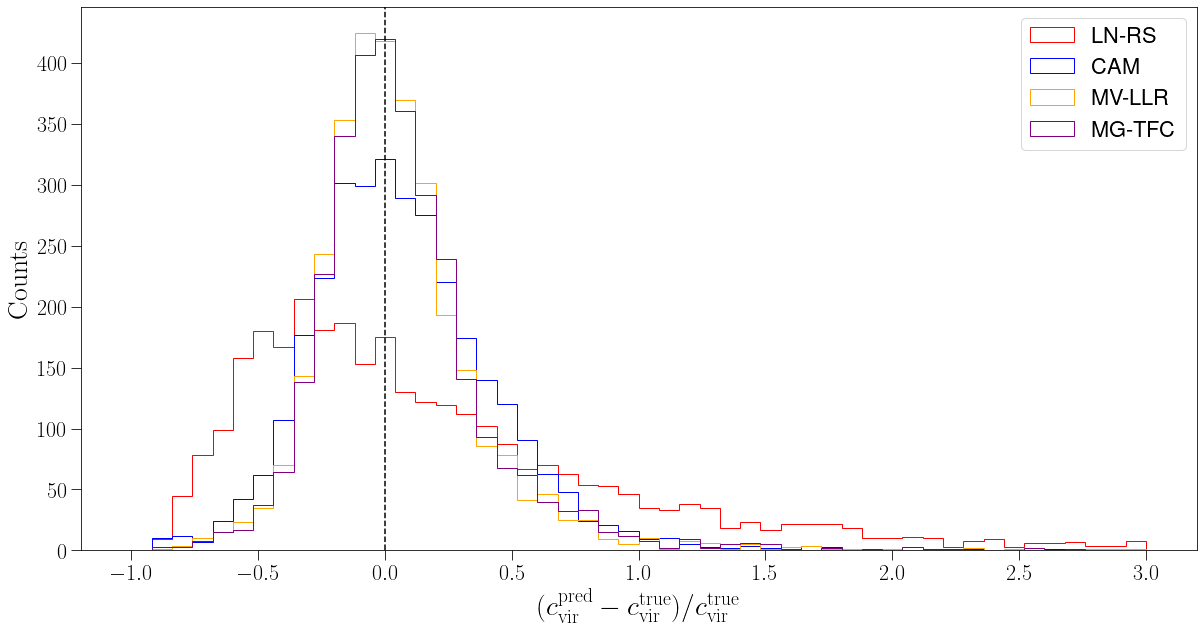

In [60]:
names = ['LN-RS', 'CAM', "MV-LLR", "MG-TFC"]
colors = ['r', 'b', 'orange', 'purple', 'g']
combined_histogram(lam_test, cvir_test, cvir_models, colors=colors, names=names, latex_var=r'c_{\rm vir}')

MV-LR corr: 0.7484739586864181
MG-TFC corr: 0.7683934989231513


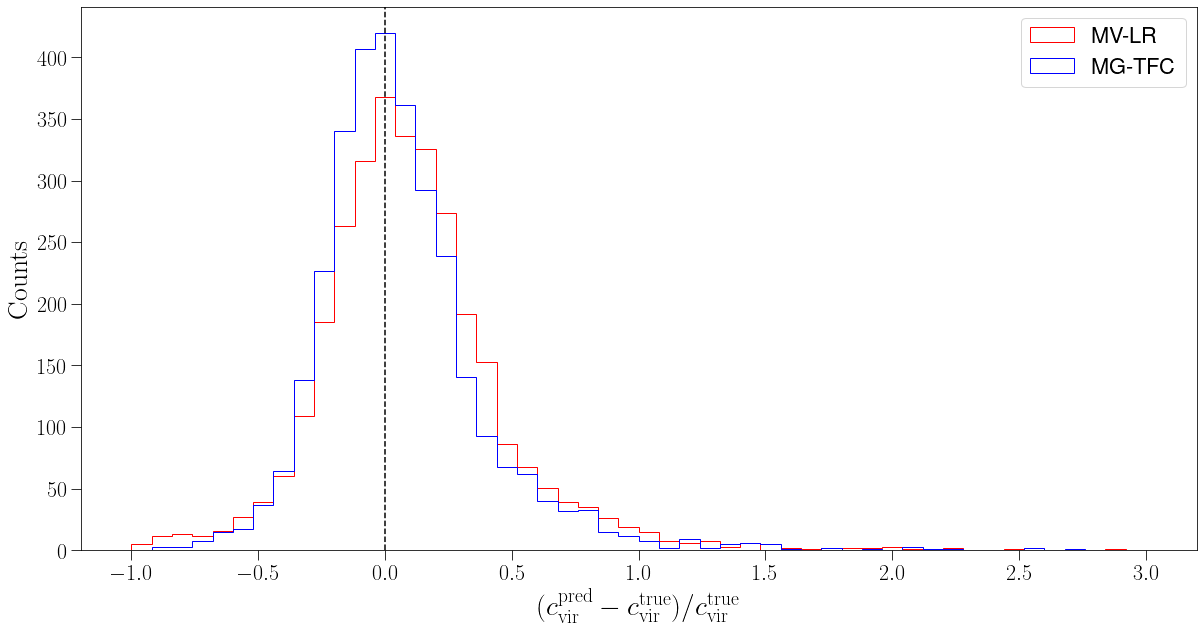

In [61]:
names = ["MV-LR", "MG-TFC"]
colors = ['r', 'b']
combined_histogram(lam_test, cvir_test, cvir_models, colors=colors, names=names, latex_var=r'c_{\rm vir}')

# we note that the quantile transformer is actually doing work in finding an optimal subspace in which to do the regression.

## Scatter plots of residuals

In [68]:
def scatter_plots(lam_test, X_test, trained_models, colors=('r',), names=('CAM',), alpha=0.5, latex_var=""): 
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, name in enumerate(names): 
        model = trained_models[name]
        X_pred = model(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        v_true = latex_var + r"^{\rm true}"
        v_pred = latex_var + r"^{\rm pred}"
        
        ax1.scatter(X_test, x, alpha=alpha, color=colors[i], label=labels[i])
        ax1.set_xlabel(f"${v_true}$")
        ax1.set_ylabel(f"${v_pred}/ {v_true}$")
        
        
        ax2.scatter(X_pred, x, alpha=alpha, color=colors[i], label=labels[i])
        ax2.set_xlabel(f"${v_pred}$")
        ax2.set_ylabel(f"${v_pred}/ {v_true}$") 
    
        ax3.scatter(a_2_test, x, alpha=alpha, color=colors[i], label=labels[i])
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(f"${v_pred}/ {v_true}$") 
        
        # add median line
        print(f'median {labels[i]}: ', np.median(x))
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

median MG-FC:  1.0044218629483483
median LN-RS:  0.9750729097508261
median CAM:  1.030928976936727
median MG-TFC:  1.0156886525765703


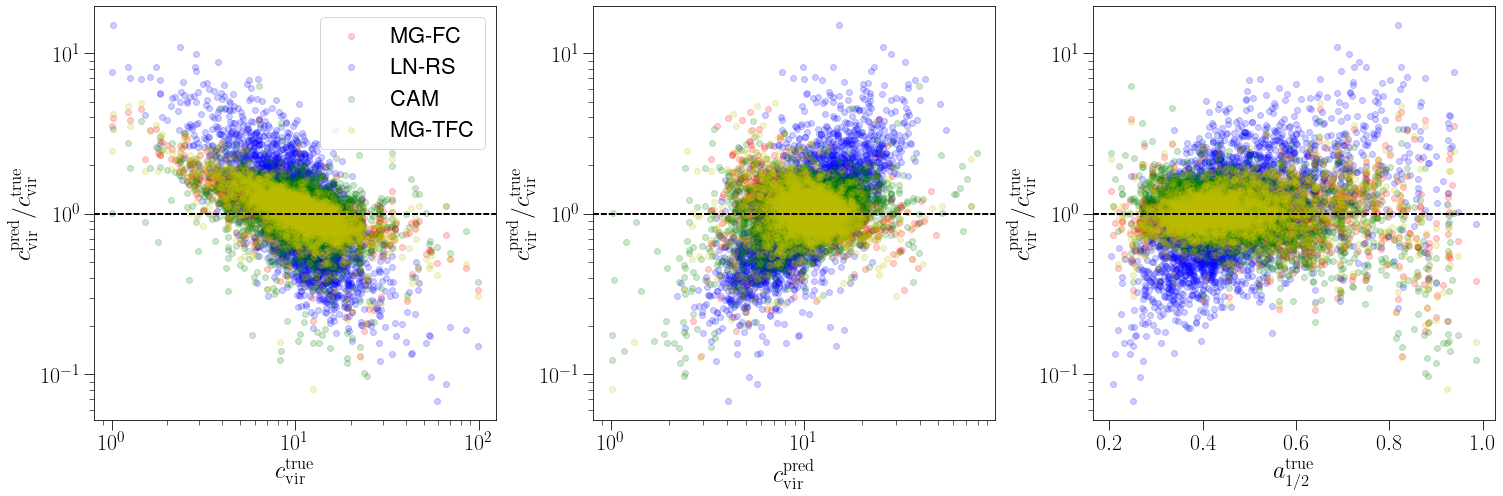

In [70]:
names = ['MV-LLR', 'LN-RS', 'CAM', 'MG-TFC']
colors = ['r', 'b', 'g', 'y']
scatter_plots(lam_test, cvir_test, cvir_models, names=names, colors=colors, alpha=0.2, latex_var=r'c_{\rm vir}')

## Median bin statistic

In [19]:
def make_scatter_binning(ax, x, y, n_xbins=15, bin_bds=None, show_bands=True, color='r', label=''):

    if bin_bds is not None:
        # ignore n_xbins
        size = len(bin_bds) - 1
        x_bds = np.array([(bin_bds[i], bin_bds[i + 1]) for i in range(size)])
    else:
        # divide uniformly.
        xs = np.linspace(np.min(x), np.max(x), n_xbins)
        x_bds = np.array([(xs[i], xs[i + 1]) for i in range(len(xs) - 1)])

    masks = [((x_bd[0] < x) & (x < x_bd[1])) for x_bd in x_bds]

    xbins = [x[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]  # remove empty ones.
    ybins = [y[mask] for mask in masks if len(x[mask]) > 0 and len(y[mask])>0]

    xmeds = np.array([np.median(xbin) for xbin in xbins])
    ymeds = np.array([np.median(ybin) for ybin in ybins])

    ax.errorbar(
        xmeds,
        ymeds,
        fmt="o-",
        color=color,
        label=label,
        capsize=10,
    )

    y1 = np.array([np.quantile(ybin, 0.25) for ybin in ybins])
    y2 = np.array([np.quantile(ybin, 0.75) for ybin in ybins])

    if show_bands:
        ax.fill_between(xmeds, y1, y2, alpha=0.2, linewidth=0.001, color=color)

In [20]:
def median_bin_statistic(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3')):
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))
    ax1, ax2, ax3 = axes.flatten()
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        a_2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
        x = X_pred / X_test
        
        make_scatter_binning(ax1, X_test, x, color=colors[i], label=labels[i])
        ax1.set_xlabel(r"$c^{\rm true}_{\rm vir}$")
        ax1.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")
        

        make_scatter_binning(ax2, X_pred, x, color=colors[i], label=labels[i])
        ax2.set_xlabel(r"$c^{\rm pred}_{\rm vir}$")
        ax2.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")    
    
        make_scatter_binning(ax3, a_2_test, x, color=colors[i], label=labels[i])
        ax3.set_xlabel(r"$a_{1/2}^{\rm true}$")
        ax3.set_ylabel(r"$c^{\rm pred}_{\rm vir}/ c^{\rm true}_{\rm vir}$")  
        
        ax1.axhline(1, ls='--', color='k')
        ax2.axhline(1, ls='--', color='k')
        ax3.axhline(1, ls='--', color='k')

        # set scales.
        ax1.set_xscale('log')
        ax2.set_xscale('log')
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')
        
        ax1.legend()
    plt.tight_layout()

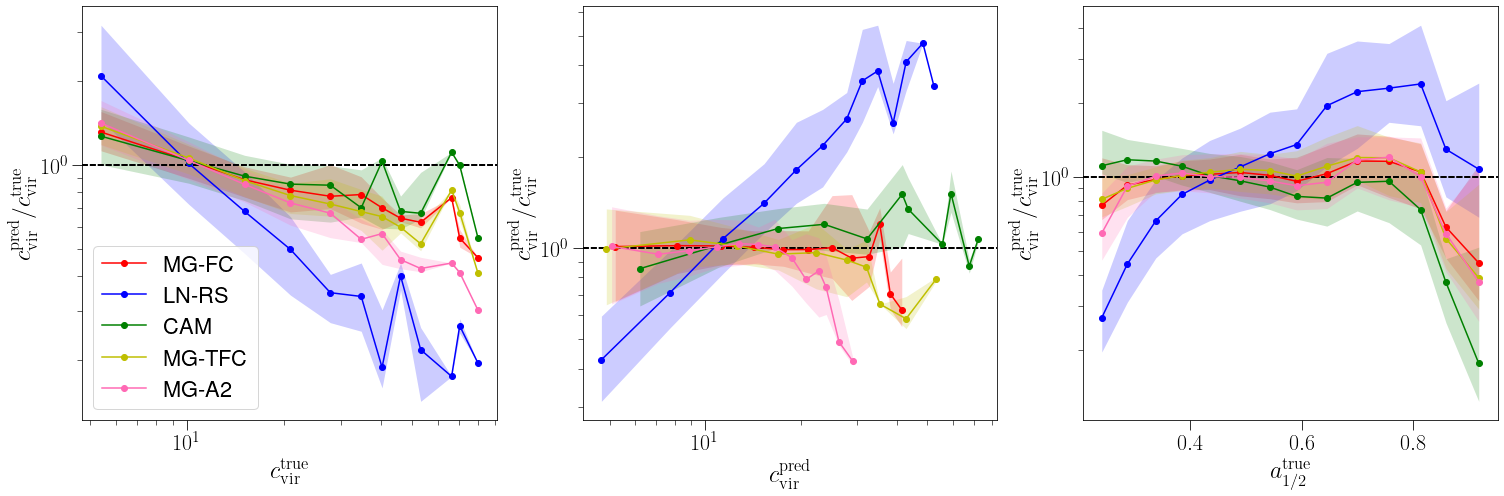

In [21]:
labels = ['MG-FC', 'LN-RS', 'CAM', 'MG-TFC', 'MG-A2']
colors = ['r', 'b', 'g', 'y', 'hotpink']
median_bin_statistic(lam_test, cvir_test, multi_gauss, lognormal, cam, multi_gauss_trans, a2_gauss, labels=labels, colors=colors)